<a href="https://colab.research.google.com/github/LxYuan0420/nlp/blob/main/notebooks/Inference_with_GIT_for_image_video_captioning_and_image_video_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: using GIT for image/video captioning and image/video question answering (QA)

This notebook showcases how to use Microsoft's GIT model for captioning of images or videos, and question answering on images or videos.

It's advised to set "runtime" to GPU as it will make generation a lot faster.

### Quick intro: GIT

GIT (short for GenerativeImage2Text) is a standard Transformer decoder, conditioned on both CLIP image patch tokens and text tokens. The goal for the model is to simply predict the next text tokens, given the image tokens and the previous text tokens.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/git_architecture.jpg" alt="drawing" width="800"/>

The model itself is pre-trained on a large collection of (image, text) pairs. Note that the authors did not open-source the big GIT and GIT-2 models, but only smaller variants called GIT-base and GIT-large (as well as a lot of fine-tuned checkpoints). Nevertheless, these models are quite impressive and probably one the best open-source variants (for the respective tasks) at the moment!

## Set-up environment

First, let's install 🤗 Transformers. We install from source here since GIT was just added at the time of writing and not yet included in a new PyPi release.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 24.1 MB/s eta 0:00:00


## Load image

Next, we can load any image we'd like.

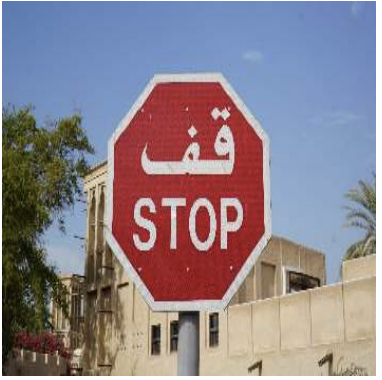

In [2]:
from huggingface_hub import hf_hub_download
from PIL import Image

filepath = hf_hub_download(repo_id="nielsr/textcaps-sample", filename="stop_sign.png", repo_type="dataset")
image = Image.open(filepath).convert("RGB")
image

## Prepare image for model

The image can be prepared for the model using `GitProcessor`. This processor includes both an image processor (for the image modality) and a tokenizer (for the text modality). Feeding it an image will make it use the image processor.

In [3]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base-textcaps")
pixel_values = processor(images=image, return_tensors="pt").pixel_values
pixel_values.shape

torch.Size([1, 3, 224, 224])

## Define model

Next, we load a GIT model from the [hub](https://huggingface.co/microsoft/git-base-textcaps). Here I'm loading a GIT based-sized model from the hub, fine-tuned on the [TextCaps](https://paperswithcode.com/dataset/textcaps) dataset (a large image captioning dataset).

In [4]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textcaps")

## Generate caption

Generating a caption for the image is as simple as calling the [generate](https://huggingface.co/docs/transformers/v4.25.1/en/main_classes/text_generation#transformers.GenerationMixin.generate) method, and passing the pixel values.

Note that we're using greedy decoding here by default, but there's a lot more, see [this blog](https://huggingface.co/blog/how-to-generate) for more info.

In [5]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
pixel_values = pixel_values.to(device)

generated_ids = model.generate(pixel_values=pixel_values, max_length=20)
print("Generated caption: ", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generated caption:  ['a stop sign with arabic writing on it']


Let's try another image that I randomly got from google.

In [8]:
from google.colab import files 
import requests
import os

google_image_url = "https://live-production.wcms.abc-cdn.net.au/daf65dd041a72ccc121e2d9d95f4be13?impolicy=wcms_crop_resize&cropH=2813&cropW=5000&xPos=0&yPos=260&width=862&height=485"

img_data = requests.get(google_image_url).content
with open('image_name.jpg', 'wb') as handler:
    handler.write(img_data)

files.download('image_name.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

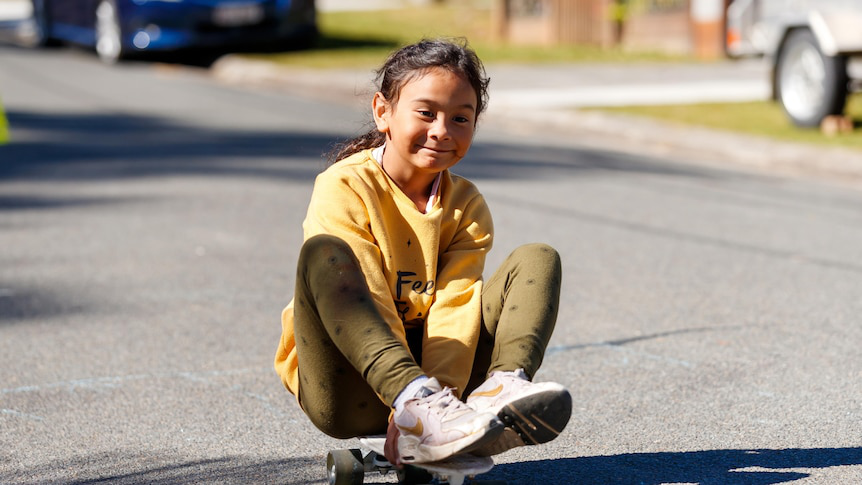

In [9]:
downloaded_image_path = "/content/image_name.jpg"
image = Image.open(downloaded_image_path).convert("RGB")
image

In [11]:
pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

generated_ids = model.generate(pixel_values=pixel_values, max_length=150)
print("Generated caption: ", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generated caption:  ['a girl wearing a yellow shirt that says " the word " on it.']


The caption is a little bit off but okay.

## All in one go

Now that we've shown image captioning, we can show all tasks in short code snippets:

- image captioning
- visual question answering (VQA)
- video captioning
- video question answering (VQA)

### Image captioning

Let's load another image to perform captioning on.

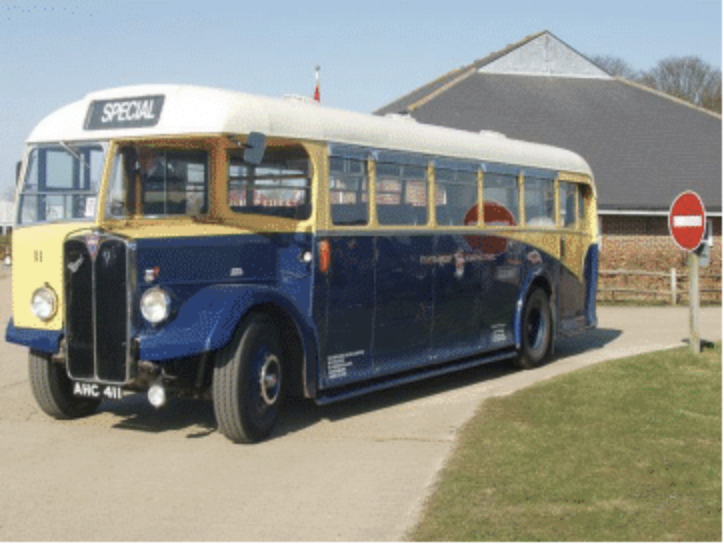

In [12]:
from huggingface_hub import hf_hub_download
from PIL import Image

def prepare_image():
  filepath = hf_hub_download(repo_id="nielsr/textvqa-sample", filename="bus.png", repo_type="dataset")
  image = Image.open(filepath).convert("RGB")
  
  return image

image = prepare_image()
image

Below we load a different GIT model from the 🤗 Hub, namely one that is fine-tuned on the COCO dataset.

In [13]:
from transformers import AutoProcessor, AutoModelForCausalLM
import torch

processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

model.to(device)
inputs = processor(images=prepare_image(), return_tensors="pt")
pixel_values = inputs.pixel_values.to(device)

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)

print("Generated caption:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generated caption: ['a bus that is parked in a driveway.']


Let's try this model on the image i got from google.

In [15]:
downloaded_image_path = "/content/image_name.jpg"
image = Image.open(downloaded_image_path).convert("RGB")

pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

generated_ids = model.generate(pixel_values=pixel_values, max_length=150)
print("Generated caption:", processor.batch_decode(generated_ids, skip_special_tokens=True))

Generated caption: ['a girl sitting on a skateboard on a street.']


Pretty simple caption but it is good that it doesnt have any mistake.

### Visual question answering (VQA)

GIT is also fine-tuned on VQA datasets, like TextVQA. Let's ask a question to the model related to the bus image.

In [16]:
processor = AutoProcessor.from_pretrained("microsoft/git-base-textvqa")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textvqa")

pixel_values = processor(images=prepare_image(), return_tensors="pt").pixel_values

question = "what does the front of the bus say at the top?"
input_ids = processor(text=question, add_special_tokens=False).input_ids
input_ids = [processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)

generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)

print("Generated answer:", processor.batch_decode(generated_ids[:, input_ids.shape[1]:], skip_special_tokens=True))

Generated answer: ['special']


In [21]:
downloaded_image_path = "/content/image_name.jpg"
image = Image.open(downloaded_image_path).convert("RGB")

pixel_values = processor(images=image, return_tensors="pt").pixel_values

question = "what is the color of the shirt the girl is wearning?"
input_ids = processor(text=question, add_special_tokens=False).input_ids
input_ids = [processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)

generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)
print("Generated answer:", processor.batch_decode(generated_ids[:, input_ids.shape[1]:], skip_special_tokens=True))

[101, 2054, 2003, 1996, 3609, 1997, 1996, 3797, 1996, 2611, 2003, 4929, 5582, 1029]
tensor([[ 101, 2054, 2003, 1996, 3609, 1997, 1996, 3797, 1996, 2611, 2003, 4929,
         5582, 1029]])
torch.Size([1, 14])
Generated answer: ['yellow']


The answer is correct.

Let's try another math question image

In [27]:
google_image_url = "https://www.basic-math-explained.com/images/xaddition-7.jpg.pagespeed.ic.1MjZ9QeHtr.webp"

img_data = requests.get(google_image_url).content
with open('math_name.jpg', 'wb') as handler:
    handler.write(img_data)

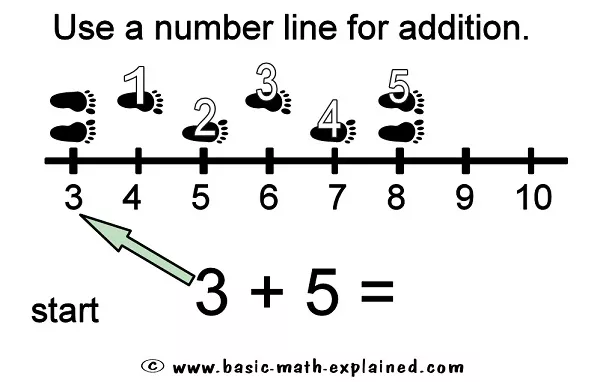

In [28]:
downloaded_image_path = "/content/math_name.jpg"
image = Image.open(downloaded_image_path).convert("RGB")
image

In [30]:
pixel_values = processor(images=image, return_tensors="pt").pixel_values

question = "What is the equation?"
input_ids = processor(text=question, add_special_tokens=False).input_ids
input_ids = [processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)

generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)
print(generated_ids.shape)
print("Generated answer:", processor.batch_decode(generated_ids[:, input_ids.shape[1]:], skip_special_tokens=True))

torch.Size([1, 9])
Generated answer: ['number line']


In [33]:
question = "What is the answer?"
input_ids = processor(text=question, add_special_tokens=False).input_ids
input_ids = [processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)

generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)
print(generated_ids.shape)
print("Generated answer:", processor.batch_decode(generated_ids, skip_special_tokens=True))

torch.Size([1, 11])
Generated answer: ['what is the answer? number line for traditional']


In [34]:
question = "What is the url on the image?"
input_ids = processor(text=question, add_special_tokens=False).input_ids
input_ids = [processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)

generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)
print(generated_ids.shape)
print("Generated answer:", processor.batch_decode(generated_ids, skip_special_tokens=True))

torch.Size([1, 14])
Generated answer: ['what is the url on the image? a number line']


In [35]:
question = "How many number can we see on the image?"
input_ids = processor(text=question, add_special_tokens=False).input_ids
input_ids = [processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)

generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids, max_length=50)
print(generated_ids.shape)
print("Generated answer:", processor.batch_decode(generated_ids, skip_special_tokens=True))

torch.Size([1, 13])
Generated answer: ['how many number can we see on the image? 1']


Conclusion: Good to use this kind of model for auto image caption for tasks where precision is not crucial. For the TextVQA part, i think the performance is not that good yet. 